Gestion de inventarios

1. Comparar Availability vs. Stock levels vs. Order quantities

Objetivo: Ver si el inventario disponible realmente satisface la demanda y cómo se relaciona con los pedidos.

Problemas que resuelve:
Detectar desajustes entre disponibilidad real y pedidos.
Identificar si se está acumulando stock sin relación con las órdenes.
Medir eficiencia de la planeación de inventarios.

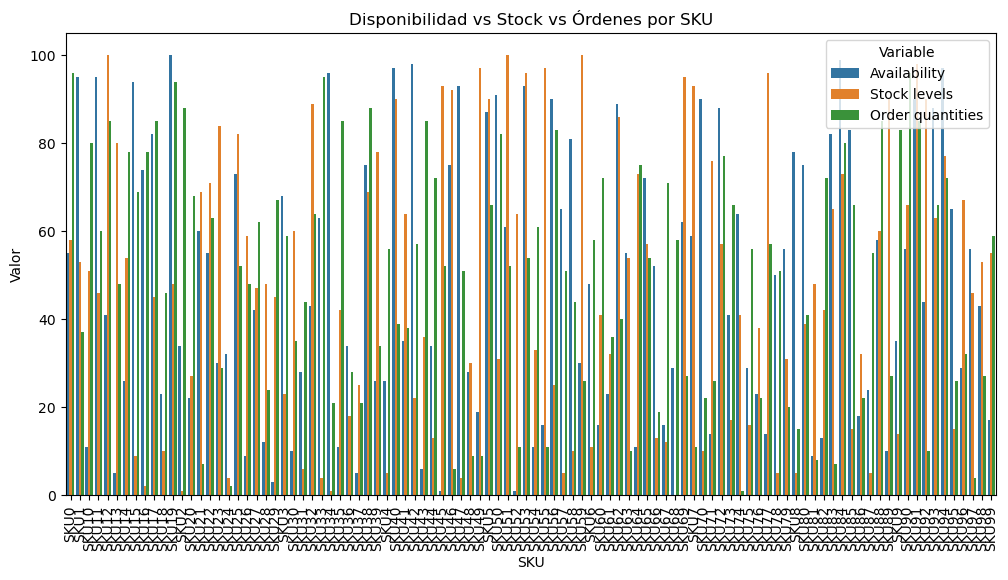

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("supply_chain_data.csv")

#Comparar disponibilidad  vs Stock vs ordenes

inventory_comp = df.groupby("SKU").agg({
    "Availability": "mean",
    "Stock levels": "mean",
    "Order quantities": "mean",
}).reset_index()

plt.figure(figsize=(12,6))
inventory_melt = inventory_comp.melt(id_vars="SKU", 
                                     value_vars=["Availability","Stock levels","Order quantities"], 
                                     var_name="Variable", value_name="Valor")

sns.barplot(x="SKU", y="Valor", hue="Variable", data=inventory_melt)
plt.xticks(rotation=90)
plt.title("Disponibilidad vs Stock vs Órdenes por SKU")
plt.show()

2.Identificación de quiebres de stock y sobreinventarios

Objetivo:

Quiebre de stock: cuando Stock levels = 0 y aún hay demanda.
Sobreinventario: cuando Stock levels > cierto umbral en relación con ventas promedio.

Problemas que resuelve:
Riesgo de ventas perdidas por quiebres.
Costos financieros y de almacenamiento por exceso de inventario.

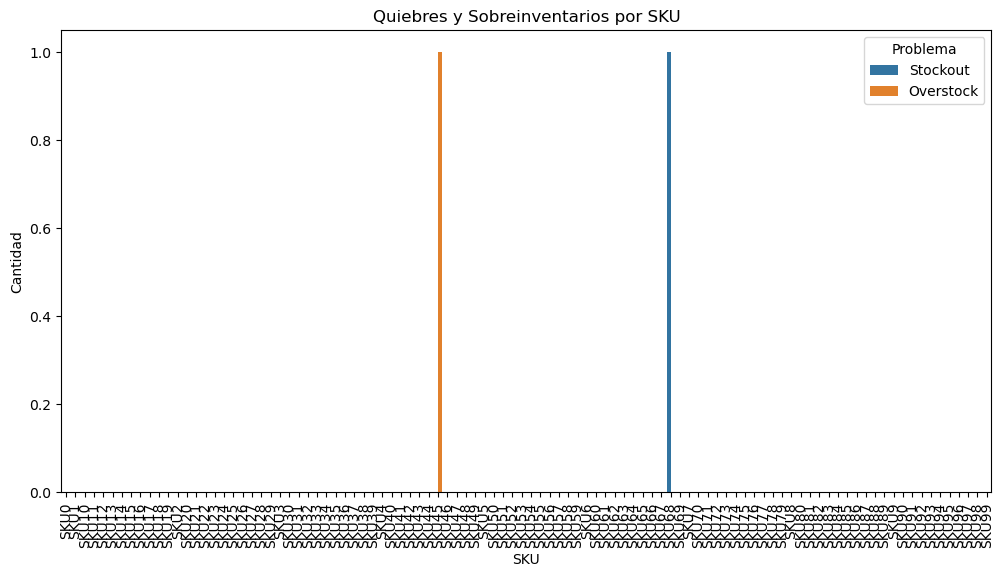

In [19]:
#Quiebre de stock y sobreinventario

#Quiebre = stock 0 pero con demanda u órdenes
df["Stockout"] = ((df["Stock levels"] == 0) & (df["Number of products sold"] > 0)).astype(int)

#Sobreinventario = stock >2x demanda promedio del sku
avg_demand = df.groupby("SKU")["Number of products sold"].mean().to_dict()
df["Overstock"]=df.apply(lambda x:1 if x["Stock levels"] > 2*avg_demand[x["SKU"]] else 0, axis=1)

stock_issues = df.groupby("SKU").agg({
    "Stockout":"sum",
    "Overstock":"sum"
}).reset_index()

plt.figure(figsize=(12,6))
stock_issues_melt = stock_issues.melt(id_vars="SKU", 
                                      value_vars=["Stockout","Overstock"], 
                                      var_name="Problema", value_name="Cantidad")

sns.barplot(x="SKU", y="Cantidad", hue="Problema", data=stock_issues_melt)
plt.xticks(rotation=90)
plt.title("Quiebres y Sobreinventarios por SKU")
plt.show()

3. Cálculo de rotación de inventarios

Objetivo: Medir cuántas veces se renueva el inventario en un periodo.
Fórmula:

Rotación de Inventarios = Ventas (COGS o Revenue) / Inventario Promedio 

Problemas que resuelve:
Inventarios lentos → capital inmovilizado.
Inventarios con alta rotación → posible riesgo de quiebres si no hay reabastecimiento oportuno.

C:\Users\marib\AppData\Local\Temp\ipykernel_4816\1268176857.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="SKU", y="Inventory_turnover", data=inv_turnover, palette="viridis")


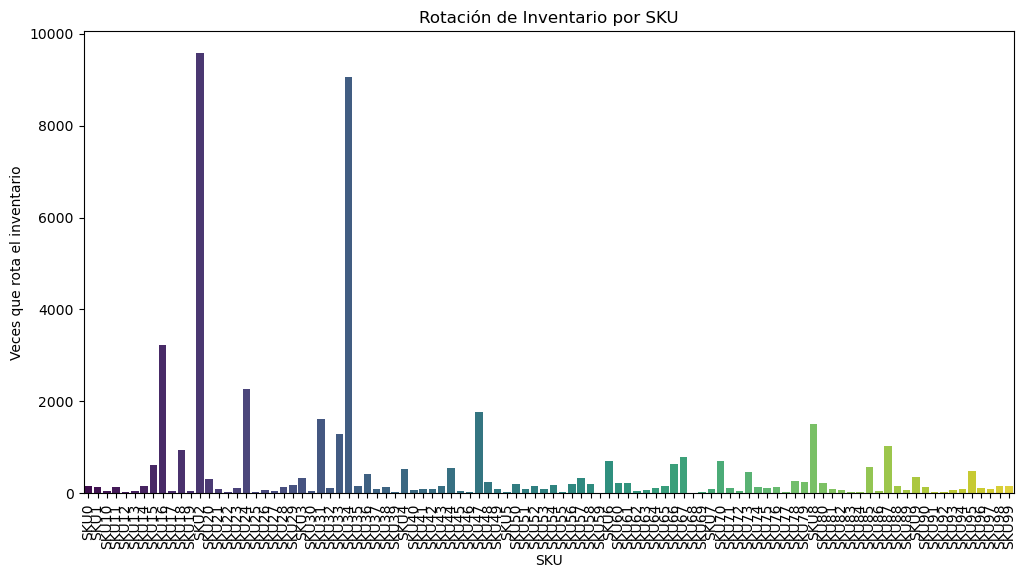

In [21]:
#Rotación de inventario
#Inventario promedio por sku

inv_avg = df.groupby("SKU")["Stock levels"].mean().reset_index(name="Avg_stock")

#Ventas totales (Revenue) por SKU
sales = df.groupby("SKU")["Revenue generated"].sum().reset_index(name="Total_sales")

#Merge
inv_turnover = pd.merge(inv_avg, sales, on="SKU")
inv_turnover["Inventory_turnover"] = inv_turnover["Total_sales"] / inv_turnover["Avg_stock"]

plt.figure(figsize=(12,6))
sns.barplot(x="SKU", y="Inventory_turnover", data=inv_turnover, palette="viridis")
plt.xticks(rotation=90)
plt.title("Rotación de Inventario por SKU")
plt.ylabel("Veces que rota el inventario")
plt.show()

In [23]:
with pd.ExcelWriter("Gestion_Inventarios.xlsx", engine="openpyxl") as writer:
    inventory_comp.to_excel(writer, sheet_name="Availability_vs_Stock", index=False)
    stock_issues.to_excel(writer, sheet_name="Stock_Issues", index=False)
    inv_turnover.to_excel(writer, sheet_name="Rotacion_Inventario", index=False)

print("✅ Archivo 'Gestion_Inventarios.xlsx' generado con éxito")

✅ Archivo 'Gestion_Inventarios.xlsx' generado con éxito
